# 6. Multiple Regression Analysis: Further Issues

In [1]:
%pip install matplotlib numpy pandas statsmodels wooldridge -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import wooldridge as wool

## 6.1 Model Formulae

### 6.1.1 Data Scaling: Arithmetic Operations witin a Formula

$$ \text{bwght} = \beta_0 + \beta_1 \cdot \text{cigs} + \beta_2 \cdot \text{faminc} + u$$

In [3]:
bwght = wool.data("bwght")

# regress and report coefficients:
reg = smf.ols(formula="bwght ~ cigs + faminc", data=bwght)
results = reg.fit()

# weight in pounds, manual way:
bwght["bwght_lbs"] = bwght["bwght"] / 16
reg_lbs = smf.ols(formula="bwght_lbs ~ cigs + faminc", data=bwght)
results_lbs = reg_lbs.fit()

# weight in pounds, direct way:
reg_lbs2 = smf.ols(formula="I(bwght/16) ~ cigs + faminc", data=bwght)
results_lbs2 = reg_lbs2.fit()

# packs of cigarettes:
reg_packs = smf.ols(formula="bwght ~ I(cigs/20) + faminc", data=bwght)
results_packs = reg_packs.fit()

# compare results:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "b_lbs": round(results_lbs.params, 4),
        "b_lbs2": round(results_lbs2.params, 4),
        "b_packs": round(results_packs.params, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                     b   b_lbs  b_lbs2   b_packs
I(cigs / 20)       NaN     NaN     NaN   -9.2682
Intercept     116.9741  7.3109  7.3109  116.9741
cigs           -0.4634 -0.0290 -0.0290       NaN
faminc          0.0928  0.0058  0.0058    0.0928



### 6.1.2 Standardization: Beta Coefficients

$$z_y = \frac{y - \bar{y}}{\text{sd}(y)}  \qquad \text{and} \qquad z_{x_1} = \frac{x_1 - \bar{x}_1}{\text{sd}(x_1)}$$

### Example 6.1: Effects of Pollution on Housing Prices

$$\text{price\_sc} = \beta_0 + \beta_1 \cdot \text{nox\_sc} + \beta_2 \cdot \text{crime\_sc} + \beta_3 \cdot \text{rooms\_sc} + \beta_4 \cdot \text{dist\_sc} + \beta_5 \cdot \text{stratio\_sc} + u$$




In [4]:
# define a function for the standardization:
def scale(x):
    x_mean = np.mean(x)
    x_var = np.var(x, ddof=1)
    x_scaled = (x - x_mean) / np.sqrt(x_var)
    return x_scaled


# standardize and estimate:
hprice2 = wool.data("hprice2")
hprice2["price_sc"] = scale(hprice2["price"])
hprice2["nox_sc"] = scale(hprice2["nox"])
hprice2["crime_sc"] = scale(hprice2["crime"])
hprice2["rooms_sc"] = scale(hprice2["rooms"])
hprice2["dist_sc"] = scale(hprice2["dist"])
hprice2["stratio_sc"] = scale(hprice2["stratio"])

reg = smf.ols(
    formula="price_sc ~ 0 + nox_sc + crime_sc + rooms_sc + dist_sc + stratio_sc",
    data=hprice2,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                 b      se        t  pval
nox_sc     -0.3404  0.0445  -7.6511   0.0
crime_sc   -0.1433  0.0307  -4.6693   0.0
rooms_sc    0.5139  0.0300  17.1295   0.0
dist_sc    -0.2348  0.0430  -5.4641   0.0
stratio_sc -0.2703  0.0299  -9.0274   0.0



### 6.1.3 Logarithms

$$\log(y) = \beta_0 + \beta_1 \log(x_1) + \beta_2 x_2 + u$$

In [5]:
hprice2 = wool.data("hprice2")

reg = smf.ols(formula="np.log(price) ~ np.log(nox) + rooms", data=hprice2)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                  b      se        t  pval
Intercept    9.2337  0.1877  49.1835   0.0
np.log(nox) -0.7177  0.0663 -10.8182   0.0
rooms        0.3059  0.0190  16.0863   0.0



### 6.1.4 Quadratics and Polynomials

$$ y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + u$$

### Example 6.2: Effects of Pollution on Housing Prices

$$\log(\text{price}) = \beta_0 + \beta_1 \log(\text{nox}) + \beta_2 \log(\text{dist}) + \beta_3 \text{rooms} + \beta_4 \text{rooms}^2 + \beta_5 \text{stratio} + u$$

In [6]:
hprice2 = wool.data("hprice2")

reg = smf.ols(
    formula="np.log(price) ~ np.log(nox)+np.log(dist)+rooms+I(rooms**2)+stratio",
    data=hprice2,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                     b      se        t    pval
Intercept      13.3855  0.5665  23.6295  0.0000
np.log(nox)    -0.9017  0.1147  -7.8621  0.0000
np.log(dist)   -0.0868  0.0433  -2.0051  0.0455
rooms          -0.5451  0.1655  -3.2946  0.0011
I(rooms ** 2)   0.0623  0.0128   4.8623  0.0000
stratio        -0.0476  0.0059  -8.1293  0.0000



### 6.1.5 Hypothesis Testing

In [7]:
hprice2 = wool.data("hprice2")
n = hprice2.shape[0]

reg = smf.ols(
    formula="np.log(price) ~ np.log(nox)+np.log(dist)+rooms+I(rooms**2)+stratio",
    data=hprice2,
)
results = reg.fit()

# implemented F test for rooms:
hypotheses = ["rooms = 0", "I(rooms ** 2) = 0"]
ftest = results.f_test(hypotheses)
fstat = ftest.statistic
fpval = ftest.pvalue

print(f"fstat: {fstat}\n")
print(f"fpval: {fpval}\n")

fstat: 110.4187819266921

fpval: 1.9193250019565814e-40



### 6.1.6 Interaction Terms

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + u$$

### Example 6.3: Effects of Attendance on Final Exam Performance

$$\text{stndfnl} = \beta_0 + \beta_1 \text{atndrte} + \beta_2 \text{priGPA} + \beta_3 \text{ACT} + \beta_4 \text{priGPA}^2 + \beta_5 \text{ACT}^2 + \beta_6 \text{atndrte} \cdot \text{priGPA} + u$$

In [8]:
attend = wool.data("attend")
n = attend.shape[0]

reg = smf.ols(
    formula="stndfnl ~ atndrte*priGPA + ACT + I(priGPA**2) + I(ACT**2)",
    data=attend,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                     b      se       t    pval
Intercept       2.0503  1.3603  1.5072  0.1322
atndrte        -0.0067  0.0102 -0.6561  0.5120
priGPA         -1.6285  0.4810 -3.3857  0.0008
atndrte:priGPA  0.0056  0.0043  1.2938  0.1962
ACT            -0.1280  0.0985 -1.3000  0.1940
I(priGPA ** 2)  0.2959  0.1010  2.9283  0.0035
I(ACT ** 2)     0.0045  0.0022  2.0829  0.0376



In [9]:
# estimate for partial effect at priGPA=2.59:
b = results.params
partial_effect = b["atndrte"] + 2.59 * b["atndrte:priGPA"]
print(f"partial_effect: {partial_effect}\n")

partial_effect: 0.007754572228608975



In [10]:
# F test for partial effect at priGPA=2.59:
hypotheses = "atndrte + 2.59 * atndrte:priGPA = 0"
ftest = results.f_test(hypotheses)
fstat = ftest.statistic
fpval = ftest.pvalue

print(f"fstat: {fstat}\n")
print(f"fpval: {fpval}\n")

fstat: 8.632581056740781

fpval: 0.003414992399585439



## 6.2 Prediction

### 6.2.1 Confidence and Prediction Intervals for Predictions

In [11]:
gpa2 = wool.data("gpa2")

reg = smf.ols(formula="colgpa ~ sat + hsperc + hsize + I(hsize**2)", data=gpa2)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
print(f"table: \n{table}\n")

table: 
                    b      se        t    pval
Intercept      1.4927  0.0753  19.8118  0.0000
sat            0.0015  0.0001  22.8864  0.0000
hsperc        -0.0139  0.0006 -24.6981  0.0000
hsize         -0.0609  0.0165  -3.6895  0.0002
I(hsize ** 2)  0.0055  0.0023   2.4056  0.0162



In [12]:
# generate data set containing the regressor values for predictions:
cvalues1 = pd.DataFrame(
    {"sat": [1200], "hsperc": [30], "hsize": [5]},
    index=["newPerson1"],
)
print(f"cvalues1: \n{cvalues1}\n")

cvalues1: 
             sat  hsperc  hsize
newPerson1  1200      30      5



In [13]:
# point estimate of prediction (cvalues1):
colgpa_pred1 = results.predict(cvalues1)
print(f"colgpa_pred1: \n{colgpa_pred1}\n")

colgpa_pred1: 
newPerson1    2.700075
dtype: float64



In [14]:
# define three sets of regressor variables:
cvalues2 = pd.DataFrame(
    {"sat": [1200, 900, 1400], "hsperc": [30, 20, 5], "hsize": [5, 3, 1]},
    index=["newPerson1", "newPerson2", "newPerson3"],
)
print(f"cvalues2: \n{cvalues2}\n")

cvalues2: 
             sat  hsperc  hsize
newPerson1  1200      30      5
newPerson2   900      20      3
newPerson3  1400       5      1



In [15]:
# point estimate of prediction (cvalues2):
colgpa_pred2 = results.predict(cvalues2)
print(f"colgpa_pred2: \n{colgpa_pred2}\n")

colgpa_pred2: 
newPerson1    2.700075
newPerson2    2.425282
newPerson3    3.457448
dtype: float64



### Example 6.5: Confidence Interval for Predicted College GPA

In [16]:
gpa2 = wool.data("gpa2")

reg = smf.ols(formula="colgpa ~ sat + hsperc + hsize + I(hsize**2)", data=gpa2)
results = reg.fit()

# define three sets of regressor variables:
cvalues2 = pd.DataFrame(
    {"sat": [1200, 900, 1400], "hsperc": [30, 20, 5], "hsize": [5, 3, 1]},
    index=["newPerson1", "newPerson2", "newPerson3"],
)

# point estimates and 95% confidence and prediction intervals:
colgpa_PICI_95 = results.get_prediction(cvalues2).summary_frame(alpha=0.05)
print(f"colgpa_PICI_95: \n{colgpa_PICI_95}\n")

colgpa_PICI_95: 
       mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  2.700075  0.019878       2.661104       2.739047      1.601749   
1  2.425282  0.014258       2.397329       2.453235      1.327292   
2  3.457448  0.027891       3.402766       3.512130      2.358452   

   obs_ci_upper  
0      3.798402  
1      3.523273  
2      4.556444  



In [17]:
# point estimates and 99% confidence and prediction intervals:
colgpa_PICI_99 = results.get_prediction(cvalues2).summary_frame(alpha=0.01)
print(f"colgpa_PICI_99: \n{colgpa_PICI_99}\n")

colgpa_PICI_99: 
       mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  2.700075  0.019878       2.648850       2.751301      1.256386   
1  2.425282  0.014258       2.388540       2.462025      0.982034   
2  3.457448  0.027891       3.385572       3.529325      2.012879   

   obs_ci_upper  
0      4.143765  
1      3.868530  
2      4.902018  



### 6.2.2 Effect Plots for Nonlinear Specifications

In [18]:
hprice2 = wool.data("hprice2")

# repeating the regression from Example 6.2:
reg = smf.ols(
    formula="np.log(price) ~ np.log(nox)+np.log(dist)+rooms+I(rooms**2)+stratio",
    data=hprice2,
)
results = reg.fit()

# predictions with rooms = 4-8, all others at the sample mean:
nox_mean = np.mean(hprice2["nox"])
dist_mean = np.mean(hprice2["dist"])
stratio_mean = np.mean(hprice2["stratio"])
X = pd.DataFrame(
    {
        "rooms": np.linspace(4, 8, num=5),
        "nox": nox_mean,
        "dist": dist_mean,
        "stratio": stratio_mean,
    },
)
print(f"X: \n{X}\n")

X: 
   rooms       nox      dist    stratio
0    4.0  5.549783  3.795751  18.459289
1    5.0  5.549783  3.795751  18.459289
2    6.0  5.549783  3.795751  18.459289
3    7.0  5.549783  3.795751  18.459289
4    8.0  5.549783  3.795751  18.459289



In [19]:
# calculate 95% confidence interval:
lpr_PICI = results.get_prediction(X).summary_frame(alpha=0.05)
lpr_CI = lpr_PICI[["mean", "mean_ci_lower", "mean_ci_upper"]]
print(f"lpr_CI: \n{lpr_CI}\n")

lpr_CI: 
        mean  mean_ci_lower  mean_ci_upper
0   9.661702       9.499811       9.823593
1   9.676940       9.610215       9.743665
2   9.816700       9.787055       9.846345
3  10.080983      10.042409      10.119557
4  10.469788      10.383361      10.556215



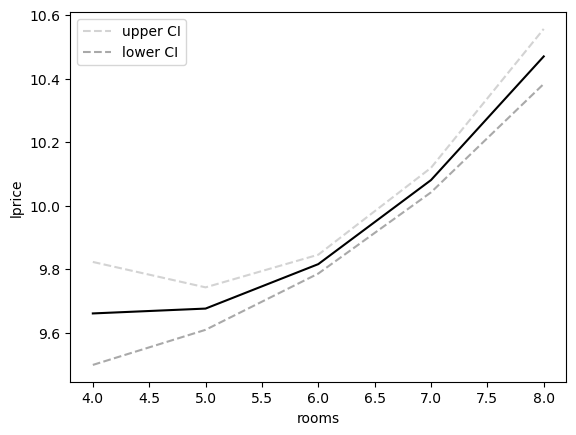

In [20]:
# plot:
plt.plot(X["rooms"], lpr_CI["mean"], color="black", linestyle="-", label="")
plt.plot(
    X["rooms"],
    lpr_CI["mean_ci_upper"],
    color="lightgrey",
    linestyle="--",
    label="upper CI",
)
plt.plot(
    X["rooms"],
    lpr_CI["mean_ci_lower"],
    color="darkgrey",
    linestyle="--",
    label="lower CI",
)
plt.ylabel("lprice")
plt.xlabel("rooms")
plt.legend()
plt.show()